In [57]:
# # Mount google drive
# from google.colab import drive
# drive.mount('/content/gdrive')

# # datasets_loc = "/content/gdrive/MyDrive/EECE568_Project_Collab/Kaggle/"

# EECE 568 Project: Deep learning and road surface type classification

In this project we explore potential classification methods using mixtures of dashcam video and passive vehicular sensor data(accelerometer, gyroscope) recorded over various  routes containing dirt, cobblestone, and asphalt roads.


**Experiment 1**: Building on a CNN that identifies road type using image frames extracted from dashcam footage, can sensor data be added to the input to augment performance? In other words, for each video frame captured every 10 seconds, additionally use some amount of sensor data measured since the last capture.

_Potential rationale_: Lighting and other obstructions in imagery may contribute to errors

## Imports

In [58]:
%matplotlib inline

import os
import cv2              # video/image processing
import numpy as np      # numpy
import pandas as pd     # data import, analysis, manipulation
import matplotlib.pyplot as plt
from sklearn import preprocessing
import gc


## Dataset: Passive Vehicular Sensors Datasets
[Kaggle URL](https://www.kaggle.com/datasets/jefmenegazzo/pvs-passive-vehicular-sensors-datasets)

```J. Menegazzo and A. von Wangenheim, "Multi-Contextual and Multi-Aspect Analysis for Road Surface Type Classification Through Inertial Sensors and Deep Learning," 2020 X Brazilian Symposium on Computing Systems Engineering (SBESC), Florianopolis, 2020, pp. 1-8, doi: 10.1109/SBESC51047.2020.9277846.```

This dataset collected by Menegazzo and von Wangenheim contains nine sets of GPS, camera, accelerometer, gyroscope, magnetometer, and temperature sensors collected in nine combinations of three drivers, three vehicles and three different routes around Anita Garibaldi in Brazil. Hardware and sensors are mounted as pictured below:

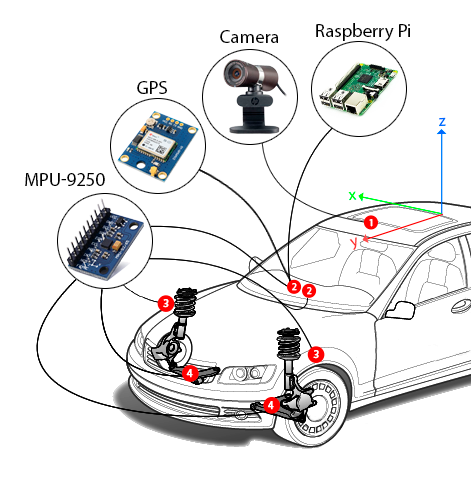

Test if dataset is present and readable

In [59]:
# with open('E:/PVS_Datasets/PVS 1/dataset_labels.csv', 'r') as input_file:
#     head = [next(input_file) for _ in range(5)]
#     input_file.seek(0)  # Reset the file pointer to the start of the file
#     line_count = sum(1 for line in input_file)
# print(head)
# print(line_count)

# with open('E:/PVS_Datasets/PVS 1/dataset_gps_mpu_right.csv', 'r') as input_file:
#     head = [next(input_file) for _ in range(5)]
#     input_file.seek(0)  # Reset the file pointer to the start of the file
#     line_count = sum(1 for line in input_file)
# print(head)
# print(line_count)


## Global Variables

In [60]:
datasets_loc = "E:/PVS_Datasets/"

# labels; one-hot encoded in DataFrames
data_class_labels = ["dirt_road", "cobblestone_road", "asphalt_road"]

# datasets to load {PVS_1, ..., PVS_9}
DATASETS_TO_LOAD = [3,9]
TESTSETS_TO_LOAD = [5]

# Video Processing
FRAME_INTERVAL = 30

CROP_VID = True
CROP_WIDTH = 300
CROP_HEIGHT = 150

REDUC_PCA = True

# training and validation batch size
BATCH_SZ = 4
# epochs
EPOCHS = 10

## Load Datasets from .csv files

In [61]:
def getDataSets(datasets_to_load, folder=datasets_loc):
    """Load raw datasets from the disk.

    Args:
        n: Number of datasets to load, from PVS_1, ..., PVS_n
        folder (str): Root folder of PVS datasets. Within this root folder are the PVS folders and their files.

    Returns:
        dict: datasets in a dict form:
        {
            "pvs_n: {
                "left": DataFrame,
                "right": DataFrame,
                "video": VideoCapture,
                "sampled_video": DataFrame, (this is done with extract_frames_to_dataframe)
                "labels": DataFrame
            }
        }
    """

    datasets = {}

    if not all(1 <= item <= 9 for item in datasets_to_load):
      raise ValueError("n must be in [1, 9]")
      return

    for i in datasets_to_load:

        dataset_folder = os.path.join(folder, "PVS " + str(i))

        left =   pd.read_csv(os.path.join(dataset_folder, 'dataset_gps_mpu_left.csv'))              #,  float_precision="high" , dtype=np.float32
        right =  pd.read_csv(os.path.join(dataset_folder, 'dataset_gps_mpu_right.csv'))             #,  float_precision="high" , dtype=np.float32
        video_path = os.path.join(dataset_folder, 'video_environment.mp4')
        video =  cv2.VideoCapture(video_path)
        labels = pd.read_csv(os.path.join(dataset_folder, 'dataset_labels.csv'), dtype=np.uint8)    #,  float_precision="high"

        datasets["pvs_" + str(i)] = {
            "left": left,
            "right": right,
            "video": video,
            "labels": labels
        }

        print(f"PVS_{i} dataset loaded")

    return datasets

In [62]:
print("----------Processing datasets----------")
datasets = getDataSets(DATASETS_TO_LOAD, datasets_loc)
print("----------Processing testsets----------")
testsets = getDataSets(TESTSETS_TO_LOAD, datasets_loc)

----------Processing datasets----------


PVS_3 dataset loaded
PVS_9 dataset loaded
----------Processing testsets----------
PVS_5 dataset loaded


In [63]:
def normalizeSensorData(which_set, i, scaler_range=(-1, 1)):
  # i: pvs_i
  # scaler_range (tuple): range to normalize to
  # returns: nothing
  datasets = which_set
  scaler = preprocessing.MinMaxScaler(feature_range=scaler_range, copy=False)

  df = datasets[f'pvs_{i}']['left']
  # normalize all columns but the first (timestamps)
  df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])

  df = datasets[f'pvs_{i}']['right']
  # normalize all columns but the first (timestamps)
  df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])

In [64]:
# normalizes all sensor data
for i in DATASETS_TO_LOAD:
  normalizeSensorData(datasets, i, scaler_range=(-1, 1))

for i in TESTSETS_TO_LOAD:
  normalizeSensorData(testsets, i, scaler_range=(-1, 1))

## Load video_environment.mp4
Here we need to:

1. Synchronize video and sensor samples in order to match the labels from the original dataset. From [PVS video/data footage](https://www.youtube.com/watch?v=AquJoKyXp1A&list=PLTG6ZC9RiP1dxQk5Wf6UiNxwRyGv-keY7&index=4)
2. Downsample the dashcam video with an arbituary frame interval. Store in the dataset dictionary
3. Crop the video frames to the center of the screen that captures the relevant environment; rids of the car hood blocking the lower part of the imagery.


In [65]:
# 1. To sync timestamps for data+video, we note the sample# which matches the start of video
if 'pvs_1' in datasets:
  datasets['pvs_1']['metadata'] = {'video_start': '2019-12-24 17:21:14', 'sample_start': 7743}
if 'pvs_2' in datasets:
  datasets['pvs_2']['metadata'] = {'video_start': '2019-12-24 17:59:54', 'sample_start': 2693}
if 'pvs_3' in datasets:
  datasets['pvs_3']['metadata'] = {'video_start': '2019-12-24 18:37:15', 'sample_start': 6481}
if 'pvs_4' in datasets:
  datasets['pvs_4']['metadata'] = {'video_start': '2019-12-25 17:46:44', 'sample_start': 0}
if 'pvs_5' in datasets:
  datasets['pvs_5']['metadata'] = {'video_start': '2019-12-25 18:17:05', 'sample_start': 1985}
if 'pvs_6' in datasets:
  datasets['pvs_6']['metadata'] = {'video_start': '2019-12-25 18:44:21', 'sample_start': 1013}
if 'pvs_7' in datasets:
  datasets['pvs_7']['metadata'] = {'video_start': '2019-12-26 18:24:10', 'sample_start': 1957}
if 'pvs_8' in datasets:
  datasets['pvs_8']['metadata'] = {'video_start': '2019-12-26 18:51:04', 'sample_start': 626}
if 'pvs_9' in datasets:
  datasets['pvs_9']['metadata'] = {'video_start': '2019-12-26 19:23:32', 'sample_start': 710}
# ----------------------------------------------------------------------
if 'pvs_1' in testsets:
  testsets['pvs_1']['metadata'] = {'video_start': '2019-12-24 17:21:14', 'sample_start': 7743}
if 'pvs_2' in testsets:
  testsets['pvs_2']['metadata'] = {'video_start': '2019-12-24 17:59:54', 'sample_start': 2693}
if 'pvs_3' in testsets:
  testsets['pvs_3']['metadata'] = {'video_start': '2019-12-24 18:37:15', 'sample_start': 6481}
if 'pvs_4' in testsets:
  testsets['pvs_4']['metadata'] = {'video_start': '2019-12-25 17:46:44', 'sample_start': 0}
if 'pvs_5' in testsets:
  testsets['pvs_5']['metadata'] = {'video_start': '2019-12-25 18:17:05', 'sample_start': 1985}
if 'pvs_6' in testsets:
  testsets['pvs_6']['metadata'] = {'video_start': '2019-12-25 18:44:21', 'sample_start': 1013}
if 'pvs_7' in testsets:
  testsets['pvs_7']['metadata'] = {'video_start': '2019-12-26 18:24:10', 'sample_start': 1957}
if 'pvs_8' in testsets:
  testsets['pvs_8']['metadata'] = {'video_start': '2019-12-26 18:51:04', 'sample_start': 626}
if 'pvs_9' in testsets:
  testsets['pvs_9']['metadata'] = {'video_start': '2019-12-26 19:23:32', 'sample_start': 710}

print(datasets[f'pvs_{DATASETS_TO_LOAD[0]}'].keys())

dict_keys(['left', 'right', 'video', 'labels', 'metadata'])


In [66]:
# crop a frame in np.ndarray((height,width,channel))
# with a rectangular box offset from the center of the frame.
def center_crop(frame, crop_width, crop_height, vertical_offset=0):
    h, w, _ = frame.shape
    start_x = w // 2 - crop_width // 2
    start_y = h // 2 - crop_height // 2 - vertical_offset
    start_y = max(0, min(h - crop_height, start_y))
    return frame[start_y:start_y+crop_height, start_x:start_x+crop_width]

In [67]:
# 2. Extract frames at 1fps (for memory/speed purposes, downscale video resolution here if needed)

def extract_frames_to_dataframe(pvs_n, dataset, frame_interval=30):

  if pvs_n in dataset:
    cap = dataset[pvs_n]['video']
  else:
    raise ValueError(f'Dataset {pvs_n} not loaded')

  if cap is None or not cap.isOpened():
    raise IOError('Could not open environment_video.mp4')
  cap.set(cv2.CAP_PROP_POS_FRAMES, 0)                    # reset to the first frame

  video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # length of video in frames
  orig_fps = int(cap.get(cv2.CAP_PROP_FPS))              # fps of OG video reported by CV

  print("video_length = ", video_length)
  print("orig_fps = ", orig_fps)
  print("frame_interval = ", frame_interval)

  frames_data = {'sample_no': [], 'frame_no': [], 'timestamp': [], 'frame': [], 'label': []}

  # get start of the data aligned to beginning of video
  offset = dataset[pvs_n]['metadata']['sample_start']
  frame_count = 0
  while cap.isOpened():
    ret, frame_bgr = cap.read()

    if not ret:
      break

    if frame_count % frame_interval == 0:
      time_stamp = cap.get(cv2.CAP_PROP_POS_MSEC)

      cropped_frame_bgr = center_crop(frame_bgr,crop_width=CROP_WIDTH,crop_height=CROP_HEIGHT,vertical_offset=50)
      cropped_frame_rgb = cv2.cvtColor(cropped_frame_bgr, cv2.COLOR_BGR2RGB)

      sample_no = offset + int(time_stamp / 10.0)
      if sample_no > dataset[pvs_n]['labels'].shape[0]:
        break
      dirt_label = dataset[pvs_n]['labels'].iloc[sample_no, 2]
      cobble_label = dataset[pvs_n]['labels'].iloc[sample_no, 3]
      asphalt_label = dataset[pvs_n]['labels'].iloc[sample_no, 4]

      frames_data['sample_no'].append(sample_no)
      frames_data['frame_no'].append(frame_count)
      frames_data['timestamp'].append(time_stamp)
      if CROP_VID:
        frames_data['frame'].append(cropped_frame_rgb)
      else:
        frames_data['frame'].append(frame_bgr)
      frames_data['label'].append([dirt_label, cobble_label, asphalt_label])

      print(f"{pvs_n}: {frame_count} / {video_length} frames processed", end='\r', flush=True)

    frame_count += 1

  cap.release()
  frames_data['sample_no'] = np.array(frames_data['sample_no'])
  frames_data['frame_no'] = np.array(frames_data['frame_no'])
  frames_data['timestamp'] = np.array(frames_data['timestamp'])
  frames_data['frame'] = np.array(frames_data['frame'])
  frames_data['label'] = np.array(frames_data['label'])

  dataset[pvs_n]['sampled_video'] = frames_data
  num_extracted = len(dataset[pvs_n]['sampled_video']['frame_no'])
  print(f"\n{pvs_n}: Video with total len={video_length} extracted with frame_interval={frame_interval} to {num_extracted} frames\n")


In [68]:
print("----------Processing datasets----------")
for i in DATASETS_TO_LOAD:
  extract_frames_to_dataframe(f'pvs_{i}', datasets, frame_interval=FRAME_INTERVAL)
print("----------Processing testsets----------")
for i in TESTSETS_TO_LOAD:
  extract_frames_to_dataframe(f'pvs_{i}', testsets, frame_interval=FRAME_INTERVAL)
print("Done")
print(datasets[f'pvs_{DATASETS_TO_LOAD[0]}']['sampled_video'].keys())
print(testsets[f'pvs_{TESTSETS_TO_LOAD[0]}']['sampled_video'].keys())

----------Processing datasets----------
video_length =  24220
orig_fps =  24
frame_interval =  30


pvs_3: 24210 / 24220 frames processed
pvs_3: Video with total len=24220 extracted with frame_interval=30 to 808 frames

video_length =  16467
orig_fps =  18
frame_interval =  30
pvs_9: 16440 / 16467 frames processed
pvs_9: Video with total len=16467 extracted with frame_interval=30 to 549 frames

----------Processing testsets----------
video_length =  33794
orig_fps =  25
frame_interval =  30
pvs_5: 33780 / 33794 frames processed
pvs_5: Video with total len=33794 extracted with frame_interval=30 to 1127 frames

Done
dict_keys(['sample_no', 'frame_no', 'timestamp', 'frame', 'label'])
dict_keys(['sample_no', 'frame_no', 'timestamp', 'frame', 'label'])


Show some example frames and associated data:

frame.shape =  (150, 300, 3)
type(frame[0][0][0]) =  <class 'numpy.uint8'>
sample_no: 6602
frame_no: 30
timestamp: 1217.196
dirt_road: 0
cobblestone_road: 0
asphalt_road: 1
label type =  <class 'numpy.uint8'>


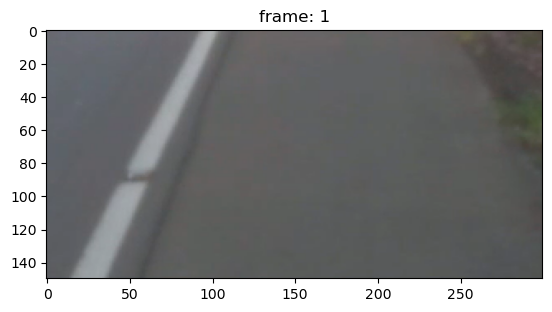

In [69]:
# show some sample frames extracted randomly from dataset, show according labels and past 5 data samples
which_dataset = DATASETS_TO_LOAD[0]
frame_index = 1
frame = datasets[f'pvs_{which_dataset}']['sampled_video']['frame'][frame_index]
print("frame.shape = ", frame.shape)
print("type(frame[0][0][0]) = ", type(frame[0][0][0]))

plt.figure()
plt.imshow(frame)
plt.title(f"frame: {frame_index}")

print(f"sample_no: {datasets[f'pvs_{which_dataset}']['sampled_video']['sample_no'][frame_index]}")
print(f"frame_no: {datasets[f'pvs_{which_dataset}']['sampled_video']['frame_no'][frame_index]}")
print(f"timestamp: {datasets[f'pvs_{which_dataset}']['sampled_video']['timestamp'][frame_index]}")
print(f"dirt_road: {datasets[f'pvs_{which_dataset}']['sampled_video']['label'][frame_index][data_class_labels.index('dirt_road')]}")
print(f"cobblestone_road: {datasets[f'pvs_{which_dataset}']['sampled_video']['label'][frame_index][data_class_labels.index('cobblestone_road')]}")
print(f"asphalt_road: {datasets[f'pvs_{which_dataset}']['sampled_video']['label'][frame_index][data_class_labels.index('asphalt_road')]}")
print("label type = ", type(datasets[f'pvs_{which_dataset}']['sampled_video']['label'][frame_index][data_class_labels.index('dirt_road')]))

frame.shape =  (150, 300, 3)
type(frame[0][0][0]) =  <class 'numpy.uint8'>
sample_no: 2100
frame_no: 30
timestamp: 1159.203
dirt_road: 0
cobblestone_road: 0
asphalt_road: 1
label type =  <class 'numpy.uint8'>


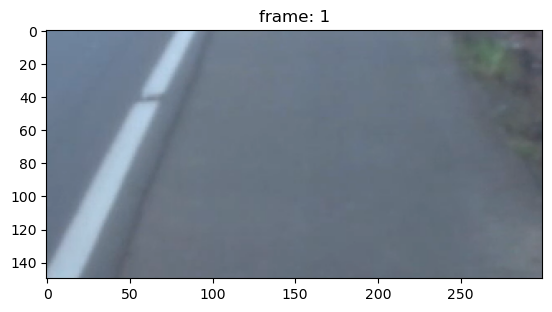

In [70]:
# show some sample frames extracted randomly from dataset, show according labels and past 5 data samples
which_testset = TESTSETS_TO_LOAD[0]
frame_index = 1
frame = testsets[f'pvs_{which_testset}']['sampled_video']['frame'][frame_index]
print("frame.shape = ", frame.shape)
print("type(frame[0][0][0]) = ", type(frame[0][0][0]))

plt.figure()
plt.imshow(frame)
plt.title(f"frame: {frame_index}")

print(f"sample_no: {testsets[f'pvs_{which_testset}']['sampled_video']['sample_no'][frame_index]}")
print(f"frame_no: {testsets[f'pvs_{which_testset}']['sampled_video']['frame_no'][frame_index]}")
print(f"timestamp: {testsets[f'pvs_{which_testset}']['sampled_video']['timestamp'][frame_index]}")
print(f"dirt_road: {testsets[f'pvs_{which_testset}']['sampled_video']['label'][frame_index][data_class_labels.index('dirt_road')]}")
print(f"cobblestone_road: {testsets[f'pvs_{which_testset}']['sampled_video']['label'][frame_index][data_class_labels.index('cobblestone_road')]}")
print(f"asphalt_road: {testsets[f'pvs_{which_testset}']['sampled_video']['label'][frame_index][data_class_labels.index('asphalt_road')]}")
print("label type = ", type(testsets[f'pvs_{which_testset}']['sampled_video']['label'][frame_index][data_class_labels.index('dirt_road')]))

## Getting Sensor Data associated with the extracted frames

In [71]:
def getSensorData(which_set, i, side, sample_num, last_m=300):
  # i: which of pvs_i from either datasets or testsets
  # sample_num: current sample at which we want to get the last_m samples
  # side is one of ['left', 'right', 'avg']
  # - 7 channels: (possibly averaged between 'left' and 'right' datasets, if 'avg' specified)
  #     - acc_x_below_suspension
  #     - acc_y_below_suspension
  #     - acc_z_below_suspension
  #     - gyro_x_below_suspension
  #     - gyro_y_below_suspension
  #     - gyro_z_below_suspension
  #     - speed
  #
  # returns Dataset of dimensions (None, m, 7).

  datasets = which_set

  if sample_num < last_m - 1:
    raise ValueError()

  if side not in ['left', 'right', 'avg']:
    raise ValueError()

  if side == 'avg':
    df_left = datasets[f'pvs_{i}']['left'].iloc[max(0, sample_num-last_m):sample_num, :]
    df_right = datasets[f'pvs_{i}']['right'].iloc[max(0, sample_num-last_m):sample_num, :]

    if not all(df_left.columns == df_right.columns):
      raise ValueError("Column names in the two DataFrames must be the same.")

    # average left and right datasets
    df_avg = pd.DataFrame()
    df_avg[df_left.columns] = (df_left + df_right) / 2

    # select relevant columns
    df_avg = df_avg.filter(regex='^(?!.*(?:dashboard|above))(speed|.*(?:acc|gyro).*)$')

    return df_avg

  df = datasets[f'pvs_{i}'][side].iloc[max(0, sample_num-last_m):sample_num, :]
  return df.filter(regex='^(?!.*(?:dashboard|above))(speed|.*(?:acc|gyro).*)$')

In [72]:
for i in DATASETS_TO_LOAD:
    print(f'Processing PVS {i}')
    datasets[f'pvs_{i}']['sampled_video']['sensor_stack'] = []
    for j in range(len(datasets[f'pvs_{i}']['sampled_video']['sample_no'])):
        sample_no = datasets[f'pvs_{i}']['sampled_video']['sample_no'][j]
        df = getSensorData(datasets, i, 'left', sample_no)
        df = df.to_numpy()
        datasets[f'pvs_{i}']['sampled_video']['sensor_stack'].append(df)
    datasets[f'pvs_{i}']['sampled_video']['sensor_stack'] = np.array(datasets[f'pvs_{i}']['sampled_video']['sensor_stack'])

print(f"no. of samples in pvs_{DATASETS_TO_LOAD[0]} = ", len(datasets[f'pvs_{DATASETS_TO_LOAD[0]}']['sampled_video']['sensor_stack']))
print(datasets[f'pvs_{DATASETS_TO_LOAD[0]}']['sampled_video']['sensor_stack'][0].shape)
print(datasets[f'pvs_{DATASETS_TO_LOAD[0]}']['sampled_video'].keys())

for i in TESTSETS_TO_LOAD:
    print(f'Processing PVS {i}')
    testsets[f'pvs_{i}']['sampled_video']['sensor_stack'] = []
    for j in range(len(testsets[f'pvs_{i}']['sampled_video']['sample_no'])):
        sample_no = testsets[f'pvs_{i}']['sampled_video']['sample_no'][j]
        df = getSensorData(testsets, i, 'left', sample_no)
        df = df.to_numpy()
        testsets[f'pvs_{i}']['sampled_video']['sensor_stack'].append(df)
    testsets[f'pvs_{i}']['sampled_video']['sensor_stack'] = np.array(testsets[f'pvs_{i}']['sampled_video']['sensor_stack'])

print(f"no. of samples in pvs_{TESTSETS_TO_LOAD[0]} = ", len(testsets[f'pvs_{TESTSETS_TO_LOAD[0]}']['sampled_video']['sensor_stack']))
print(testsets[f'pvs_{TESTSETS_TO_LOAD[0]}']['sampled_video']['sensor_stack'][0].shape)
print(testsets[f'pvs_{TESTSETS_TO_LOAD[0]}']['sampled_video'].keys())

Processing PVS 3
Processing PVS 9
no. of samples in pvs_3 =  808
(300, 7)
dict_keys(['sample_no', 'frame_no', 'timestamp', 'frame', 'label', 'sensor_stack'])
Processing PVS 5
no. of samples in pvs_5 =  1127
(300, 7)
dict_keys(['sample_no', 'frame_no', 'timestamp', 'frame', 'label', 'sensor_stack'])


## Stacking all loaded PVS into one input-output set

In [73]:
# For datasets
print("Processing datasets")
for i, j in zip(np.arange(len(DATASETS_TO_LOAD)), DATASETS_TO_LOAD):
    if i == 0:
        X_frames = datasets[f'pvs_{j}']['sampled_video']['frame'] / 255.0
        X_sensor = datasets[f'pvs_{j}']['sampled_video']['sensor_stack']
        Y = datasets[f'pvs_{j}']['sampled_video']['label']
    else:
        X_frames = np.append(X_frames, datasets[f'pvs_{j}']['sampled_video']['frame'] / 255.0, axis=0)
        X_sensor = np.append(X_sensor, datasets[f'pvs_{j}']['sampled_video']['sensor_stack'], axis=0)
        Y = np.append(Y, datasets[f'pvs_{j}']['sampled_video']['label'], axis=0)

print("X_frames.shape = ", X_frames.shape)
print("X_sensor.shape = ", X_sensor.shape)
print("Y.shape = ", Y.shape)
print("type(X) = ", type(X_frames[0][0][0][0]))
print("type(Y) = ", type(Y[0][0]))

# For testsets
print("Processing testsets")
for i, j in zip(np.arange(len(TESTSETS_TO_LOAD)), TESTSETS_TO_LOAD):
    if i == 0:
        X_test_frames = testsets[f'pvs_{j}']['sampled_video']['frame'] / 255.0
        X_test_sensor = testsets[f'pvs_{j}']['sampled_video']['sensor_stack']
        Y_test = testsets[f'pvs_{j}']['sampled_video']['label']
    else:
        X_test_frames = np.append(X_test_frames, testsets[f'pvs_{j}']['sampled_video']['frame'] / 255.0, axis=0)
        X_test_sensor = np.append(X_test_sensor, testsets[f'pvs_{j}']['sampled_video']['sensor_stack'], axis=0)
        Y_test = np.append(Y_test, testsets[f'pvs_{j}']['sampled_video']['label'], axis=0)

print("X_test_frames.shape = ", X_test_frames.shape)
print("X_test_sensor.shape = ", X_test_sensor.shape)
print("Y_test.shape = ", Y_test.shape)
print("type(X_test_frames) = ", type(X_test_frames[0][0][0][0]))
print("type(Y_test) = ", type(Y_test[0][0]))

del datasets, testsets
gc.collect()

Processing datasets
X_frames.shape =  (1357, 150, 300, 3)
X_sensor.shape =  (1357, 300, 7)
Y.shape =  (1357, 3)
type(X) =  <class 'numpy.float64'>
type(Y) =  <class 'numpy.uint8'>
Processing testsets
X_test_frames.shape =  (1127, 150, 300, 3)
X_test_sensor.shape =  (1127, 300, 7)
Y_test.shape =  (1127, 3)
type(X_test_frames) =  <class 'numpy.float64'>
type(Y_test) =  <class 'numpy.uint8'>


7543

## Processing images with PCA

- Flatten the frames actually helps PCA itentify inter channel relations
- Due to the flattening, PCA might intrinsically not good at recognizing spatial patterns
- Might consider the following instead:
    - Use another CNN to reduce image dimension before combining with sensor data
    - Other texture classification technique
        - Gabor filters
        - Local Binary Patterns (LBP)
        - https://chat.openai.com/share/c50e09eb-2a03-4383-a5ce-3424dfc157cc

In [74]:
if REDUC_PCA:
    from sklearn.decomposition import PCA

In [75]:
if REDUC_PCA:
    n_frames, h, w, d = X_frames.shape
    X_frames = X_frames.reshape(n_frames, -1)
    print('X_frames.shape = ', X_frames.shape)

    pca = PCA(n_components=300)
    pca.fit(X_frames)
    print("shape of principal components:", pca.components_.shape)

X_frames.shape =  (1357, 135000)


shape of principal components: (300, 135000)


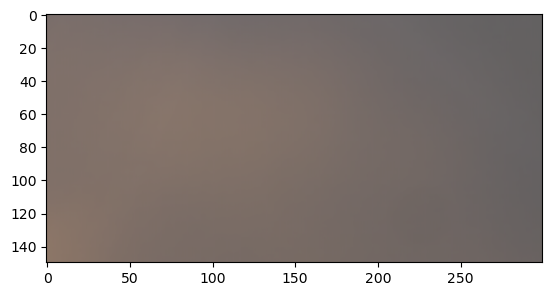

In [76]:
if REDUC_PCA:
    plt.imshow(pca.mean_.reshape([h,w,d]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


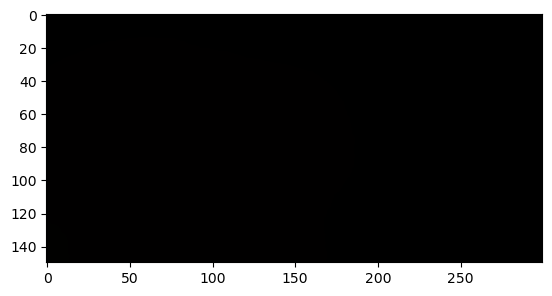

In [77]:
if REDUC_PCA:
    plt.imshow(pca.components_[0].reshape([h,w,d]))

In [78]:
if REDUC_PCA:
    def get_rmse(original, reconstructed):
        return np.sqrt(((original - reconstructed) ** 2).mean())

In [79]:
if REDUC_PCA:
    X_frames_pca = pca.transform(X_frames)
    X_recon = pca.inverse_transform(X_frames_pca)

    n_frames, h, w, d = X_test_frames.shape
    X_test_frames = X_test_frames.reshape(n_frames, -1)
    X_test_pca = pca.transform(X_test_frames)
    X_test_recon = pca.inverse_transform(X_test_pca)

    print("Original shape:   ", X_frames.shape)
    print("Transformed shape:", X_frames_pca.shape)
    print("Reconstructed shape:", X_recon.shape)
    print('\n')
    print ("RMSE reconstruction:", get_rmse(X_frames, X_recon))
    print ("RMSE reconstruction:", get_rmse(X_test_frames, X_test_recon))

    X_frames = X_frames_pca
    X_test_frames = X_test_pca
    
    del X_frames_pca, X_test_pca

Original shape:    (1357, 135000)
Transformed shape: (1357, 300)
Reconstructed shape: (1357, 135000)


RMSE reconstruction: 0.007923234054882631
RMSE reconstruction: 0.03179090981439278


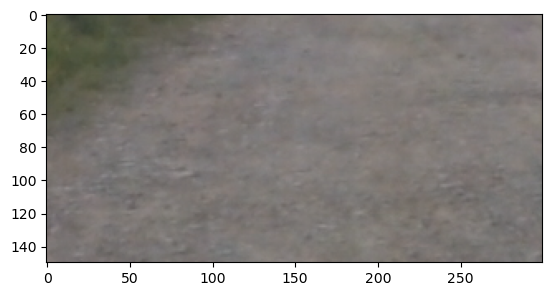

In [80]:
if REDUC_PCA:
    plt.imshow(X_recon[150].reshape([h,w,d]))
    
    del X_recon
    

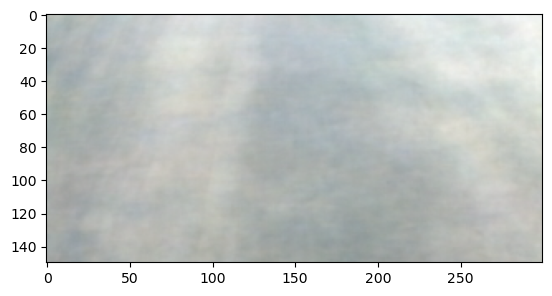

In [81]:
if REDUC_PCA:
    plt.imshow(X_test_recon[150].reshape([h,w,d]))
    
    del X_test_recon
    gc.collect()

## Building a model in Tensorflow

Input data format: tbd


Output format: probabilities length 3

In [82]:
# To-Do: https://chat.openai.com/share/c50e09eb-2a03-4383-a5ce-3424dfc157cc


In [83]:
import tensorflow as tf
import tensorflow.keras.layers as tf_layers
from sklearn.model_selection import train_test_split


In [84]:
batch_size = BATCH_SZ

X_frames = X_frames.reshape((X_frames.shape[0], X_frames.shape[1],1))
X = np.concatenate((X_frames, X_sensor), axis=-1)

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)


print("X.shape = ", X.shape)
print("Y.shape = ", Y.shape)
print("X_train.shape = ", X_train.shape)
print("X_valid.shape = ", X_valid.shape)
print("Y_train.shape = ", Y_train.shape)
print("Y_valid.shape = ", Y_valid.shape)

X_test_frames = X_test_frames.reshape((X_test_frames.shape[0], X_test_frames.shape[1],1))
X_test = np.concatenate((X_test_frames, X_test_sensor), axis=-1)
print("X_test.shape = ", X_test.shape)
print("Y_test.shape = ", Y_test.shape)

X.shape =  (1357, 300, 8)
Y.shape =  (1357, 3)
X_train.shape =  (1085, 300, 8)
X_valid.shape =  (272, 300, 8)
Y_train.shape =  (1085, 3)
Y_valid.shape =  (272, 3)
X_test.shape =  (1127, 300, 8)
Y_test.shape =  (1127, 3)


In [85]:
# Creating tf datasets
with tf.device('/cpu:0'):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    train_dataset = train_dataset.shuffle(len(X_train)).batch(batch_size)

    valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))
    valid_dataset = train_dataset.shuffle(len(X_valid)).batch(batch_size)

    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
    test_dataset = test_dataset.shuffle(len(X_test)).batch(batch_size)

for x, y in train_dataset.take(1):
    print("shape of 1 batch of train_dataset: ", x.shape)
for x, y in valid_dataset.take(1):
    print("shape of 1 batch of valid_dataset: ", x.shape)
for x, y in test_dataset.take(1):
    print("shape of 1 batch of test_dataset: ", x.shape)

shape of 1 batch of train_dataset:  (4, 300, 8)
shape of 1 batch of valid_dataset:  (4, 4, 300, 8)
shape of 1 batch of test_dataset:  (4, 300, 8)


In [86]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = tf_layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')
        self.relu1 = tf_layers.ReLU()
        self.pool1 = tf_layers.MaxPooling1D(pool_size=2, strides=2)
        self.conv2 = tf_layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same')
        self.relu2 = tf_layers.ReLU()
        self.pool2 = tf_layers.MaxPooling1D(pool_size=2, strides=2)
        self.flatten = tf_layers.Flatten()
        # Adjust the size of the input to the fully connected layer
        self.dense = tf_layers.Dense(3)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense(x)
        pred_label = tf.nn.softmax(x, axis=1)

        return {'label': pred_label}

# Create an instance of the model
model = MyModel()

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [87]:
# Train the model
model.fit(train_dataset, epochs=EPOCHS)

Epoch 1/10


272/272 [==============================] - 2s 4ms/step - loss: 0.4665 - accuracy: 0.7963
Epoch 2/10
272/272 [==============================] - 1s 3ms/step - loss: 0.2383 - accuracy: 0.9032
Epoch 3/10
272/272 [==============================] - 1s 3ms/step - loss: 0.1473 - accuracy: 0.9419
Epoch 4/10
272/272 [==============================] - 1s 3ms/step - loss: 0.1161 - accuracy: 0.9585
Epoch 5/10
272/272 [==============================] - 1s 3ms/step - loss: 0.0646 - accuracy: 0.9871
Epoch 6/10
272/272 [==============================] - 1s 3ms/step - loss: 0.0482 - accuracy: 0.9853
Epoch 7/10
272/272 [==============================] - 1s 3ms/step - loss: 0.0351 - accuracy: 0.9908
Epoch 8/10
272/272 [==============================] - 1s 3ms/step - loss: 0.0211 - accuracy: 0.9972
Epoch 9/10
272/272 [==============================] - 1s 3ms/step - loss: 0.0090 - accuracy: 0.9991
Epoch 10/10
272/272 [==============================] - 1s 3ms/step - loss: 0.0061 - accuracy: 1.0000
